# Recommendations with IBM

Several recommendation methods are investigated on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
# Import the necessary libraries and packages

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Import test modules
import project_tests as t

# Packages and libraries for content based recs

import re

# nlp packages
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# data processing packages
from sklearn.feature_extraction.text import TfidfVectorizer

# import linear kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Use 2 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 90)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", 20)

In [3]:
# Read in the data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [4]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * ...,Here’s this week’s news in Data Science and Big Data.,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDI...","Learn how distributed DBs solve the problem of scaling persistent storage, but introdu...",DataLayer Conference: Boost the performance of your distributed database,Live,3
4,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",This video demonstrates the power of IBM DataScience Experience using a simple New Yor...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

First we provide some insight into the descriptive statistics of the data.

`1.` _What is the distribution of how many articles a user interacts with in the dataset?  Visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article._  

In [6]:
# The number of unique emails
print("The number of unique user emails is {}.".format(df.email.nunique()))

The number of unique user emails is 5148.


In [7]:
# The number of unique articles 
print("The number of unique articles is {}.".format(df_content.article_id.nunique()))

The number of unique articles is 1051.


In [8]:
# Table to keep track of the articles accessed by a user
articles_per_user = pd.pivot_table(df,
                    values=['article_id'],
                    index='email',
                    aggfunc={'article_id': list})
articles_per_user.reset_index(inplace=True)

# Check the outcome
articles_per_user.head()

,email,article_id
0,0000b6387a0366322d7fbfc6434af145adf7fed1,"[1314.0, 732.0, 173.0, 1354.0, 43.0, 1232.0, 1162.0, 124.0, 1337.0, 349.0, 43.0, 288.0..."
1,001055fc0bb67f71e8fa17002342b256a30254cd,"[124.0, 1386.0, 254.0, 390.0]"
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,"[1386.0, 932.0, 258.0]"
3,001a852ecbd6cc12ab77a785efa137b2646505fe,"[349.0, 957.0, 1364.0, 593.0, 1364.0, 232.0]"
4,001fc95b90da5c3cb12c501d201a915e4f093290,"[1364.0, 379.0]"


In [9]:
# Create a new column that records how many articles a user accessed
articles_per_user['articles_count'] = [len(x) for x in articles_per_user.article_id]

# Create a column that records how many unique articles the user accessed
articles_per_user['unique_articles_count'] = [len(set(x)) for x in articles_per_user.article_id]

# Check the outcome
articles_per_user.sort_values(by='articles_count', ascending=False)

,email,article_id,articles_count,unique_articles_count
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,"[362.0, 409.0, 409.0, 302.0, 409.0, 14.0, 29.0, 1293.0, 1429.0, 1293.0, 720.0, 1304.0,...",364,135
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,"[943.0, 658.0, 109.0, 43.0, 1170.0, 1172.0, 1314.0, 43.0, 1338.0, 1160.0, 1276.0, 33.0...",363,135
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,"[173.0, 1165.0, 1427.0, 651.0, 1274.0, 1165.0, 1274.0, 1425.0, 202.0, 1293.0, 1429.0, ...",170,97
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,"[1293.0, 409.0, 20.0, 1165.0, 1430.0, 1175.0, 939.0, 1425.0, 1368.0, 1274.0, 1175.0, 1...",169,97
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,"[930.0, 1057.0, 1314.0, 793.0, 1368.0, 1396.0, 1368.0, 1396.0, 793.0, 427.0, 833.0, 13...",160,96
...,...,...,...,...
565,1b520f0f65c0aee52d4235f92fb2de58fa966635,[1166.0],1,1
2481,7a67e4a2902a20062e1f2a6835b6e099b34b4f6c,[50.0],1,1
4003,c4b7e639e91b1d18e5b9c000f0ad3354888fcdde,[115.0],1,1
2483,7a7fb282789944665ffc1cddee5ddbdbd7ca9f64,[299.0],1,1


In [10]:
# How many users accessed one article only
one_article_users = articles_per_user[articles_per_user['articles_count'] == 1]
one_article_users.shape

(1416, 4)

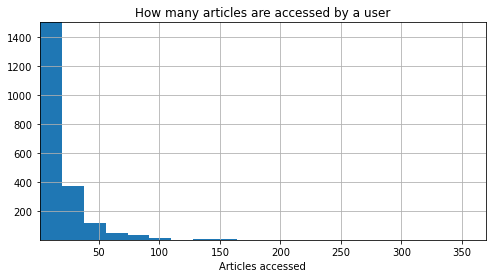

In [11]:
# The histogram of the data
plt.figure(figsize=(8,4))
plt.hist(articles_per_user.articles_count, bins=20)

# Add labels and title
plt.xlabel('Articles accessed')
plt.title('How many articles are accessed by a user')
plt.xlim(1, 370)
plt.ylim(1, 1500)
plt.grid(True)
plt.show()

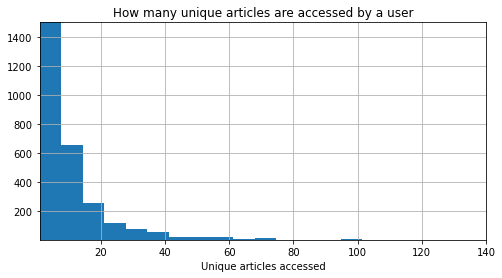

In [12]:
# The histogram of the data
plt.figure(figsize=(8,4))
plt.hist(articles_per_user.unique_articles_count, bins=20)

# Add labels and title
plt.xlabel('Unique articles accessed')
plt.title('How many unique articles are accessed by a user')
plt.xlim(1, 140)
plt.ylim(1, 1500)
plt.grid(True)
plt.show()

In [13]:
# 5 numbers descriptive statistics for the number of articles accessed by users
articles_per_user.describe()

,articles_count,unique_articles_count
count,5148.00,5148.00
mean,8.93,6.54
std,16.80,9.99
min,1.00,1.00
25%,1.00,1.00
50%,3.00,3.00
75%,9.00,7.00
max,364.00,135.00


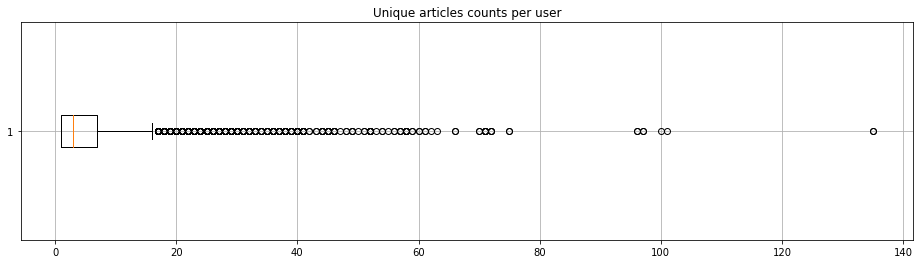

In [14]:
# Boxplot for the unique articles accessed by a user

plt.figure(figsize=(16,4))
plt.boxplot(articles_per_user.unique_articles_count, vert=False)

plt.title('Unique articles counts per user')
plt.grid(True)
plt.show()

In [15]:
# Dataframe to record the number of times each user interacts with an article
article_user = df.value_counts(ascending=False).to_frame('counts').reset_index()
article_user.head()

,article_id,title,email,counts
0,1170.0,"apache spark lab, part 1: basic concepts",1588af175b283915f597fc4719cbb2c8621c4fc2,42
1,1170.0,"apache spark lab, part 1: basic concepts",363cb98a087e4a3eb6890fd1af2d418116f85ff8,41
2,1429.0,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,35
3,1429.0,use deep learning for image classification,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,35
4,1429.0,use deep learning for image classification,c8afd6f4620184042cc48ca0eba9a657ac89e90e,25


In [16]:
# 5 Values descriptive statistics for how many times users interact with one article
article_user.describe()

,article_id,counts
count,33669.00,33669.00
mean,848.38,1.37
std,492.26,1.18
min,0.00,1.00
25%,349.00,1.00
50%,996.00,1.00
75%,1320.00,1.00
max,1444.00,42.00


In [17]:
# Fill in the median and maximum number of user_article interactions below

median_val = df.groupby('email').count()['article_id'].median()
print('50% of individuals interact with {} articles or fewer.'.format(median_val))
max_views_by_user = df.groupby('email').count()['article_id'].max()
print('The maximum number of user-article interactions by any user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any user is 364.


`2.` _Explore and remove duplicate articles from the `df_content` dataframe._

In [18]:
# Find and explore duplicate articles
duplicate_articles = df_content[df_content['article_id'].duplicated()]
duplicate_articles.shape

(5, 5)

In [19]:
duplicate_articles

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data ...,During the seven-week Insight Data Engineering Fellows Program recent grads and experi...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * Home\r\n * Data Science Experience\r\n * ...,One of the earliest documented catalogs was compiled at the great library of Alexandri...,How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
761,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n ...,"Today’s world of data science leverages data from various sources. Commonly, these sou...",Using Apache Spark as a parallel processing framework for accessing REST based data se...,Live,398
970,This video shows you how to construct queries to access the primary index through the ...,This video shows you how to construct queries to access the primary index through the API,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Ca...,"If you are like most data scientists, you are probably spending a lot of time to clean...",Self-service data preparation with IBM Data Refinery,Live,232


In [20]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

# Check the outcome
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` _In the cells below we find:_

**a.** _The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset._

In [21]:
# The articles with no email/user interaction in the df dataframe
df[df.isna().any(axis=1)]

,article_id,title,email
25131,1016.0,why you should master r (even if it might eventually become obsolete),NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and notebooks in dsx,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excluding unnecessary details,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [22]:
# The number of unique articles that have no user interaction in the df dataframe
df[df.isna().any(axis=1)]['article_id'].nunique()

13

In [23]:
unique_articles = df.article_id.nunique()
print('The number of unique articles that have at least one interaction is {}.'.format(unique_articles))
total_articles = df_content.article_id.nunique()
print('The number of unique articles on the IBM platform is {}.'.format(total_articles))
unique_users = df.email.nunique()
print('The number of unique users is {}.'.format(unique_users))
user_article_interactions = df[['email', 'article_id']].shape[0]
print('The number of user-article interactions is {}'.format(user_article_interactions))

The number of unique articles that have at least one interaction is 714.
The number of unique articles on the IBM platform is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993


`4.` _In the cells below we find the most viewed `article_id`, as well as how often it was viewed. After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below)._

In [24]:
# Count how many times each article is viewed
df.groupby('article_id').count()['email'].sort_values(ascending=False).head(5)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [25]:
# The most viewed article
df.loc[1429]

article_id                                       528.0
title                10 tips on using jupyter notebook
email         7888dc37498447d0477be7ee2c4176543f5a6190
Name: 1429, dtype: object

In [26]:
# The full information on the article NOTE: the 1 unit shift in article id between dataframes!!
df_content.loc[529]

doc_body           Homepage About membership Sign in Get started Homepage Roman Kierzkowski Blocked Unblo...
doc_description    Jupyter Notebook (a.k.a iPython Notebook) is brilliant coding tool. It is ideal for do...
doc_full_name                                                              10 tips on using Jupyter Notebook
doc_status                                                                                              Live
article_id                                                                                               528
Name: 529, dtype: object

In [27]:
most_viewed_article_id = str(df.groupby('article_id').count()['email'].sort_values(ascending=False).index[0])
print('The most viewed article_id in the dataset is {}.'.format(most_viewed_article_id))
max_views = df.groupby('article_id').count()['email'].sort_values(ascending=False).iloc[0]
print('The most viewed article in the dataset was viewed {} times.'.format(max_views))

The most viewed article_id in the dataset is 1429.0.
The most viewed article in the dataset was viewed 937 times.


In [28]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
# Testing unit for the above defined variables

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

This dataset does not contain ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` _The next function returns the **n** top articles ordered with most interactions at the top. The function is also tested below._

In [30]:
# Test the approach used in the function
list(df.groupby('title').count()['user_id'].sort_values(ascending=False).index[:2])

['use deep learning for image classification',
 'insights from new york car accident reports']

In [31]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top n article titles 
    
    '''
    
    top_articles = list(df.groupby('title').count()['user_id'].sort_values(ascending=False).index[:n])
    # Return the top article titles from df 
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article tids
    
    '''
    
    top_articles_ids = list(df.groupby('article_id').count()['user_id'].sort_values(ascending=False).index[:n])
    # Return the top article ids
    return top_articles_ids 

In [32]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [33]:
# Test the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of the three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the `df` dataframe to be shaped with users as the rows and articles as the columns.  

* Each `user` appears in each row once.

* Each `article` shows up in only one `column`.  

* **If a user has interacted with an article, a 1 is placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article are **1**.  

* **If a user has not interacted with an item, a zero is placed where the user-row meets for that article-column**. 

The tests are used to make sure the basic structure of the matrix matches what is expected by the solution.

In [34]:
# Create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df (pandas dataframe) - article_id, title, user_id are the columns
    
    OUTPUT:
    user_item (nd array) - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns,
    with 1 values where a user interacted with an article and a 0 otherwise.
    '''
    
    # Create new column that keeps track of user_article interaction
    df['interact'] = 1
    # Transform df so that every user is on a row and every article corresponds to a column
    user_item = df.groupby(['user_id', 'article_id'])['interact'].first().unstack()
    # Fill in NaN with 0 in the user_item matrix
    user_item.fillna(0, inplace = True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [35]:
# Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` _The function below takes a `user_id` and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided `user_id`, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

_We use the tests to test the function._

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarities = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    sorted_similarities = user_similarities.sort_values(ascending=False)

    # create list of just the ids
    similars = list(sorted_similarities.index)
   
    # remove the own user's id
    most_similar_users = similars[1:]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [37]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` _Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  The functions below return the articles we would recommend to each user._

In [38]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = [df[df['article_id'] == float(x)]['title'].unique()[0] for x in article_ids]
    # Return the article names associated with list of article ids
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str').to_list()
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # articles_seen by user (we don't want to recommend these)
    articles_seen = get_user_articles(user_id, user_item)[0]
    # find the similar users
    similar_users = find_similar_users(user_id)
    
    # list of recommended articles
    recs = []
    
    for user in similar_users:
        user_list = get_user_articles(user, user_item)[0]
        recs_update = np.setdiff1d(user_list, articles_seen)
        recs.extend(np.setdiff1d(recs_update, recs))
     
        if len(recs) >= m:
            break
    
    return recs[:m] # return recommendations for this user_id    

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [40]:
# Test the functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` _Now we are going to improve the consistency of the **user_user_recs** function from above._

* _Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions._

* _Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function written earlier._

In [41]:
# get a sample user id
user_id = 17

In [42]:
# order the other users based on similarity
neighbor_id = find_similar_users(user_id)
len(neighbor_id)

5148

In [43]:
# record the similarity measure, i.e. the dot product with user_id 
similarity = [user_item.loc[neighbor].dot(user_item.loc[user_id]) for neighbor in neighbor_id]

In [44]:
# find the number of views for each user
num_interactions = [df[df['user_id'] == x].shape[0] for x in neighbor_id]

In [45]:
# create a dictionary 
neighbors_df = {'neighbor_id': neighbor_id,
               'similarity': similarity,
               'num_interactions': num_interactions}

In [46]:
# create a dataframe from dictionary
neighbors_df = pd.DataFrame(data=neighbors_df)

In [47]:
# check the output
neighbors_df.head()

,neighbor_id,similarity,num_interactions
0,3691,28.0,33
1,23,12.0,364
2,3782,12.0,363
3,170,11.0,116
4,3169,11.0,114


In [48]:
# sort the values
neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False).head(2)

,neighbor_id,similarity,num_interactions
0,3691,28.0,33
1,23,12.0,364


In [49]:
# print the information of the user_id we started with
neighbors_df.loc[user_id]

neighbor_id         72.0
similarity           8.0
num_interactions    49.0
Name: 17, dtype: float64

In [50]:
# create a list of the most simlar users
neighbor_list = neighbor_id[:10]
neighbor_list

[3691, 23, 3782, 170, 3169, 49, 3764, 3697, 98, 256]

In [51]:
# get one member from the neighbors list
user = neighbor_list[1]
user

23

In [52]:
 # get the articles seen by the similar user
similar_seen = get_user_articles(user, user_item)[0]
len(similar_seen)

135

In [53]:
# the articles seen by user_id member
articles_seen =  get_user_articles(user_id, user_item)[0]
articles_seen[:4]

['108.0', '146.0', '158.0', '162.0']

In [54]:
# remove the articles seen by user_id from neighbor's list
# these are the articles to recommend
articles_to_rec = np.setdiff1d(similar_seen, articles_seen)
len(articles_to_rec)

123

In [55]:
# the final list of articles to recommend
recs_ids = []
# the articles seen by similar user to add to the recommended list
# remove those articles already in the list
articles_to_add = np.setdiff1d(articles_to_rec, recs_ids)
len(articles_to_add)

123

In [56]:
# for the next step we need article ids as float or integer
articles_ids = [float(x) for x in articles_to_add]
articles_ids[:2]

[1000.0, 1014.0]

In [57]:
# sort the article ids
df_reduced=df[df['article_id'].isin(articles_ids)]
df_reduced.groupby('article_id').count()['title'].sort_values(ascending=False).index.to_list()[:2]

[1429.0, 1330.0]

In [58]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # order the other users based on similarity with member user_id
    neighbor_id = find_similar_users(user_id)
    # record the similarity measure, i.e. the dot product with user_id 
    similarity = [user_item.loc[neighbor].dot(user_item.loc[user_id]) for neighbor in neighbor_id]
    # find the number of views/interactions for each user
    num_interactions = [df[df['user_id'] == x].shape[0] for x in neighbor_id]
    
    # create a dataframe 
    neighbors_df = pd.DataFrame(data={'neighbor_id': neighbor_id,
                                      'similarity': similarity,
                                      'num_interactions': num_interactions})
    # drop the row corresponding to the member user_id
    neighbors_df.drop(user_id, axis = 0, inplace = True)
    
    # sort by similarity and num_interactions                 
    neighbors_df.sort_values(by = ['similarity', 'num_interactions'], 
                             inplace=True, 
                             ascending=(False, False))   
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # list of recommended articles by id, and by title
    recs_ids = []
    
    # articles_seen by user (we don't want to recommend these)
    articles_seen = get_user_articles(user_id, user_item)[0]
    
    # similar users with most article views
    similar_users = get_top_sorted_users(user_id, df, user_item)
    
    for user in similar_users['neighbor_id'].values:
        
        # get the articles seen by the similar user
        similar_seen = get_user_articles(user, user_item)[0]
        
        # remove the articles in articles_seen
        articles_to_rec = np.setdiff1d(similar_seen, articles_seen)
        
        # remove the articles already added to the recs list
        articles_to_add = np.setdiff1d(articles_to_rec, recs_ids)
        
        # rewrite the recommended article ids as float 
        articles_ids = [float(x) for x in articles_to_add]
        
        # sort the articles by popularity, i.e. number of views
        df_red = df[df['article_id'].isin(articles_ids)]
        sorted_articles=df_red.groupby('article_id').count()['title'].sort_values(ascending=False).index.to_list()
       
        # add the sorted article ids
        recs_ids.extend(sorted_articles)
        
        # break when we have enough articles to recommend
        if len(recs_ids) >= m:
            break
    
    # retain the first m recommendations
    recs = recs_ids[:m]
    
    # get the articles names
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names


In [59]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` _Based on the functions from above to we fill in the solutions to the dictionary below. Then test the dictionary against the solution. The code needed to answer each of the following comments below is provided._

In [60]:
# Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df, user_item).loc[0]['neighbor_id']
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df, user_item).loc[10]['neighbor_id']

In [61]:
print(user1_most_sim, user131_10th_sim)

3933.0 242.0


In [62]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` _If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users._

**For a new use we recommend the most popular articles on the website, through `get_top_articles` and `get_top_article_ids` functions, as we don't have any information about user's preferences.**

`7.` _Using the existing functions, we provide the top 10 recommended articles we would provide for a new user below. Test the function against the standard solution._

In [63]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df) # Your recommendations here

In [64]:
# rewrite recommendations as a set of strings
new_user_recs = [str(x) for x in new_user_recs]

In [65]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0',
                                  '1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops! It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. We could consider content to be the `doc_body`, `doc_description`, or `doc_full_name`.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` _We will create a content based recommender based on `doc_description` and `full_doc_title` columns._  

`2.` _We choose the most popular recommendations that meet the content criteria._

#### Investigate and Prepare the Data

In [66]:
# make copies of the data
df_copy = df.copy()
df_content_copy = df_content.copy()

In [67]:
# take a look at the data
df_copy.columns

Index(['article_id', 'title', 'user_id', 'interact'], dtype='object')

In [68]:
# get the data types in df
df_copy.dtypes

article_id    float64
title          object
user_id         int64
interact        int64
dtype: object

In [69]:
# change datatype of article id in df
df_copy['article_id'] = df_copy['article_id'].astype('int')

# check the output
df_copy.dtypes

article_id     int64
title         object
user_id        int64
interact       int64
dtype: object

In [70]:
# look at the titles in df
df_copy.title[1:4]

1    healthcare python streaming application demo
2      use deep learning for image classification
3       ml optimization using cognitive assistant
Name: title, dtype: object

In [71]:
# lowercase all titles in df dataframe
df_copy['title'] = df_copy['title'].apply(lambda x: x.lower())

In [72]:
# take a look at the content data
df_content_copy.columns

Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')

In [73]:
# get the data types in df_content
df_content_copy.dtypes

doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

In [74]:
# take a closer look at the data
df_content_copy.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",Communicating data science: A guide to presenting your work,Live,1


In [75]:
# rename the column doc_full_name to title
df_content_copy.rename(columns={'doc_full_name': 'title'}, inplace = True)

In [76]:
# lower case all the article titles
df_content_copy['title'] = df_content_copy['title'].apply(lambda x: x.lower())

# check the outcome
df_content_copy.head()

,doc_body,doc_description,title,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,detect malfunctioning iot sensors with streaming analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",communicating data science: a guide to presenting your work,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * ...,Here’s this week’s news in Data Science and Big Data.,"this week in data science (april 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDI...","Learn how distributed DBs solve the problem of scaling persistent storage, but introdu...",datalayer conference: boost the performance of your distributed database,Live,3
4,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",This video demonstrates the power of IBM DataScience Experience using a simple New Yor...,analyze ny restaurant data using spark in dsx,Live,4


In [77]:
# form a dataframe that has  columns: title, doc_description and article_id 
df_cont = df_content_copy[['article_id', 'title']]

# check the output
df_cont.head()

,article_id,title
0,0,detect malfunctioning iot sensors with streaming analytics
1,1,communicating data science: a guide to presenting your work
2,2,"this week in data science (april 18, 2017)"
3,3,datalayer conference: boost the performance of your distributed database
4,4,analyze ny restaurant data using spark in dsx


In [78]:
# create a dataframe for article titles in df
df_titles = df_copy[['article_id', 'title']]

df_titles.head()

,article_id,title
0,1430,"using pixiedust for fast, flexible, and easier data analysis and experimentation"
1,1314,healthcare python streaming application demo
2,1429,use deep learning for image classification
3,1338,ml optimization using cognitive assistant
4,1276,deploy your python model as a restful api


In [79]:
# check for missing values
df_titles.isnull().sum()

article_id    0
title         0
dtype: int64

In [80]:
# remove the duplicates from dataframe df_titles
df_titles = df_titles[~df_titles.duplicated()]

In [81]:
# combine the two dataframes so all available articles are included
df_full = pd.merge(df_cont, df_titles,
                  left_on = ['article_id', 'title'],
                  right_on = ['article_id', 'title'],
                  how = 'outer')

# check the outcome
df_full.shape

(1341, 2)

In [82]:
# preview the output
df_full.head()

,article_id,title
0,0,detect malfunctioning iot sensors with streaming analytics
1,1,communicating data science: a guide to presenting your work
2,2,"this week in data science (april 18, 2017)"
3,3,datalayer conference: boost the performance of your distributed database
4,4,analyze ny restaurant data using spark in dsx


In [83]:
# check for missing values
df_full.isnull().sum()

article_id    0
title         0
dtype: int64

#### Pre-process the Text and Create TF-IDF Matrix

In [84]:
def tokenize(text):
    
    """
    Contains the pre-processing steps for a document:
        - tokenize
        - lemmatize
        - lowercasing
        - removes stopwords in English language
        
    INPUT (string) - raw message
    OUTPUT (list)  - clean tokens
    """
    
    # remove punctuation and unusual characters 
    text = re.sub(r"[^a-zA-Z0-9]", " ", text).strip()
    
    # split into words
    words = word_tokenize(text)
    
    # lemmatize - reduce words to their root form
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    # case normalize and remove leading & trailing empty spaces
    words = [w.lower().strip() for w in words]
    
    # remove stopwords, keep not and can
    clean_words = [w for w in words if w not in stopwords.words('english') 
                   or w in ['not', 'can']]
    
    return clean_words

In [85]:
# create an instance of the TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# construct the TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(df_full['title'])

In [86]:
# output the shape of the tfidf matrix
tfidf_matrix.shape

(1341, 1970)

#### Compute the cosine similarity scores

In [87]:
# compute the cosine similarity matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# check the output
cosine_sim.shape

(1341, 1341)

#### Build the recommender function

In [88]:
def get_article_info(article_id, df_full):
    '''
    INPUT:
    article_id - (integer)
    df_full - (pandas dataframe) contains article_id, title
    
    OUTPUT:
    article_title - (string) the article name associated with the provided article id
    '''
    
    article_title = df_full[df_full['article_id']==article_id]['title'].unique()[0]
    return article_id, article_title

In [89]:
# print a sample output

print('The title of the article with id = 542 is: {}.'.format(get_article_info(542, df_full)[1]))

The title of the article with id = 542 is: getting started with python.


In [132]:
# Function that takes in the article id as input and gives n recommendations
def content_recommender(article_id, n, cosine_sim, df_full):
    '''
    INPUT:
    article_id - (integer)
    n - (integer) how many recommendations should be returned
    cosine_sim  - (np.ndarray) matrix of cosine similarities
    df - (pandas dataframe) contains title and article id
    
    OUTPUT:
    recommended_articles  - (list) article ids and titles that are recommended, 
                             sorted by cosine similarity
    '''
    # get the information for the given article id
    given_art = get_article_info(article_id, df_full)
    
    # obtain the matrix index that matches the article id
    mat_index = df_full[df_full['article_id']==article_id].index.values[0]
    
    # sort the scores based on the cosine similarity scores with given article index, ignore the first entry
    sim_scores = pd.Series(cosine_sim[mat_index]).sort_values(ascending=False).iloc[1:]
    
    # get the indices corresponding to the scores of the n most similar articles
    sim_scores_n = list(sim_scores[:n+1].index.values)
    
    # return the top n most similar article_ids as a pandas dataframe
    recommended_articles = df_full.iloc[sim_scores_n]
    
    return given_art, recommended_articles

In [140]:
# give recommendations for the article with id 20
article_id = 20
rec_id20 = content_recommender(article_id, 10, cosine_sim, df_full)
rec_id20

((20, 'working interactively with rstudio and notebooks in dsx'),
      article_id                                                       title
 373         373                               working with notebooks in dsx
 763         763                  load data into rstudio for analysis in dsx
 182         182                              overview of rstudio ide in dsx
 355         355                    run shiny applications in rstudio in dsx
 626         626       analyze db2 warehouse on cloud data in rstudio in dsx
 665         665                       get social with your notebooks in dsx
 958         958                  using dsx notebooks to analyze github data
 474         474                          publish notebooks to github in dsx
 930         930  how to use version control (github) in rstudio within dsx?
 821         821                using rstudio in ibm data science experience
 395         395                             run dsx notebooks on amazon emr)

In [138]:
# the article ids for the recommended articles for article_id=20
rec_id20[1]['article_id'].tolist()

[373, 763, 182, 355, 626, 665, 958, 474, 930, 821, 395]

In [139]:
# make recommendations for article id 224 based on title
content_recommender(224, 5, cosine_sim, df_full)

((224, 'using apply, sapply, lapply in r'),
       article_id                                                  title
 103          103                    how to scale your analytics using r
 986          986                                     r for data science
 694          694       predict temperatures using dashdb, python, and r
 919          919  watson speech-to-text services — tl;dr need not apply
 933          933                                          workflow in r
 1204        1056                               access postgresql with r)

#### Make Content Recommendations

In [149]:
def make_content_recs(user_id, cosine_sim, m=10, df=df, df_full=df_full):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df - (pandas dataframe) contains user and articles interactions
    df_full - (pandas dataframe) contains title and article id
    
    OUTPUT:
    recs_ids - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the articles based on closeness to the articles seen by the user.
    For each article seen by the user - finds n most similar articles based on content recommendations.
    Does this until m recommendations are found.
    
    Notes:
    * Choose the articles that have the most total article interactions 
    before choosing those with fewer article interactions.
   
    '''
    # list of recommended articles by id, and by title
    recommendations = []
    
    # articles_seen by user 
    articles_seen = get_user_articles(user_id, user_item)[0]
    
    # rewrite the recommended article ids as int
    articles_ids_seen = [int(x[:-2]) for x in articles_seen]
    
    for art_id in articles_ids_seen:
        
        # get the n most similar articles 
        n = 10
        similar_articles = content_recommender(art_id, n, cosine_sim, df_full)[1]['article_id'].tolist()

        # remove the articles in articles_seen and available
        articles_to_rec = np.setdiff1d(similar_articles, articles_ids_seen)
        
        # remove the articles already added to the recs list
        articles_to_add = np.setdiff1d(articles_to_rec, recommendations)
        
        # add the sorted article ids
        recommendations.extend(articles_to_add)
        
        # break when we have enough articles to recommend
        if len(recs_ids) >= m:
            break
    
    # retain the first m recommendations
    recs = recommendations[:m]
    
    # get the articles titles
    complete_recs = [get_article_info(int(idx), df_full) for idx in recs]
    
    return complete_recs


In [144]:
# articles seen by user 40
articles_seen = get_user_articles(40, user_item)[0]
articles_ids_seen = [float(x) for x in articles_seen]
articles_info = [get_article_info(index, df_full) for index in articles_ids_seen]
articles_info

[(43.0, 'deep learning with tensorflow course by big data university'),
 (109.0, 'tensorflow quick tips'),
 (111.0, 'tidy up your jupyter notebooks with scripts'),
 (112.0, 'building custom machine learning algorithms with apache systemml'),
 (164.0, 'learn tensorflow and deep learning together and now!'),
 (213.0, 'modeling energy usage in new york city'),
 (225.0,
  'a visual explanation of the back propagation algorithm for neural networks'),
 (232.0, 'self-service data preparation with ibm data refinery'),
 (313.0, 'what is machine learning?'),
 (337.0, 'generalization in deep learning'),
 (379.0, 'data structures related to machine learning algorithms'),
 (482.0, 'using deep learning with keras to predict customer churn'),
 (528.0, '10 tips on using jupyter notebook'),
 (667.0, 'imitation learning in tensorflow (hopper from openai gym)'),
 (684.0, 'flexdashboard: interactive dashboards for r'),
 (723.0, '10 essential algorithms for machine learning engineers'),
 (903.0, 'an attemp

In [150]:
# recommendations for user 40 based on title content
make_content_recs(40, cosine_sim, 10, df, df_full)

[(237, 'deep learning with data science experience'),
 (278, 'deep learning trends and an example'),
 (295, 'awesome deep learning papers'),
 (336, 'challenges in deep learning'),
 (500, 'the difference between ai, machine learning, and deep learning?'),
 (604, 'the 3 cs of big data'),
 (947, 'big data is better data'),
 (1004, 'how to get a job in deep learning'),
 (207, 'compose tips: dates and dating in mongodb'),
 (263, "december '16 rstudio tips and tricks")]

In [151]:
# articles seen by user 178
articles_seen = get_user_articles(178, user_item)[0]
articles_ids_seen = [int(x[:-2]) for x in articles_seen]
articles_info = [get_article_info(index, df_full)[0] for index in articles_ids_seen]
articles_info

[310, 362, 460, 878]

In [152]:
# recommendations for user 178 based on title content
make_content_recs(178, cosine_sim, 10, df, df_full)

[(142, 'neural networks for beginners: popular types and applications'),
 (225,
  'a visual explanation of the back propagation algorithm for neural networks'),
 (303, 'backpropagation — how neural networks learn complex behaviors'),
 (464, 'use ibm data science experience to detect time series anomalies'),
 (465, 'introduction to neural networks, advantages and applications'),
 (641, 'perform sentiment analysis with lstms, using tensorflow'),
 (662, 'build deep learning architectures with neural network modeler'),
 (785, 'interactive time series with dygraphs'),
 (862, 'time series analysis using max/min and neuroscience'),
 (887,
  'forgetting the past to learn the future: long short-term memory neural networks for time series prediction')]

`2.` _Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?_

**The content based recommendations are based on the article title or on the article description. The corpus consists of one group of these documents. The text is processed by removing punctuation and stop words, it is lemmatized and split into tokens. Once processed the corpus is fed into a TdIdf Vectorizer that creates a matrix of scores. The cosine similarities between any two documents (rows in the similarity matrix) are computed and the results are saved in a 1051x1051 matrix.**

**Given a user id, and assuming that the user has seen at least one article, the engine will recommend n content similar articles for each article seen by the user. Once this collection is created, it is sorted using the article popularity and m most popular articles are recommended.**

**One way to improve these results is to use more efficient NLP techniques, such as word embedding. Another option would be to create meta data for the articles based on their descriptions and full text, both available in the `df_content` dataframe. 

`3.` _Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations._

In [153]:
# make recommendations for a brand new user - recommend the most popular articles
new_user_recs = get_top_article_ids(10, df) 
new_user_recommendations = [get_article_info(art_id, df_full) for art_id in new_user_recs]
new_user_recommendations

[(1429.0, 'use deep learning for image classification'),
 (1330.0, 'insights from new york car accident reports'),
 (1431.0, 'visualize car data with brunel'),
 (1427.0, 'use xgboost, scikit-learn & ibm watson machine learning apis'),
 (1364.0, 'predicting churn with the spss random tree algorithm'),
 (1314.0, 'healthcare python streaming application demo'),
 (1293.0,
  'finding optimal locations of new store using decision optimization'),
 (1170.0, 'apache spark lab, part 1: basic concepts'),
 (1162.0, 'analyze energy consumption in buildings'),
 (1304.0, 'gosales transactions for logistic regression model')]

In [154]:
# make recommendations for a user who only has interacted with article id '1427.0'
content_recommender(1427, 10, cosine_sim, df_full)

((1427, 'use xgboost, scikit-learn & ibm watson machine learning apis'),
       article_id                                                               title
 124          124                      python machine learning: scikit-learn tutorial
 809          809                                    use the machine learning library
 313          313                                           what is machine learning?
 1317        1175                breast cancer detection with xgboost, wml and scikit
 893          893  use the machine learning library in ibm analytics for apache spark
 161          161                           use the machine learning library in spark
 437          437                            ibm watson machine learning: get started
 122          122                              watson machine learning for developers
 1320        1298                    from scikit-learn model to cloud with wml client
 685          685                     working with data flows using

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many articles can we make predictions for in the test set?': # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])